In [1]:
import numpy as np
import pandas as pd

def sin(a, f, t, sr=44_100.0):
    return a * np.sin(2 * np.pi * f * (t / sr))

a = 2
f = 100
d = 1_000
sr = 44_100.0
ns = d * (sr / 1000.0)
t = np.arange(0, int(ns))

y = sin(a, f, t, sr)


<Axes: >

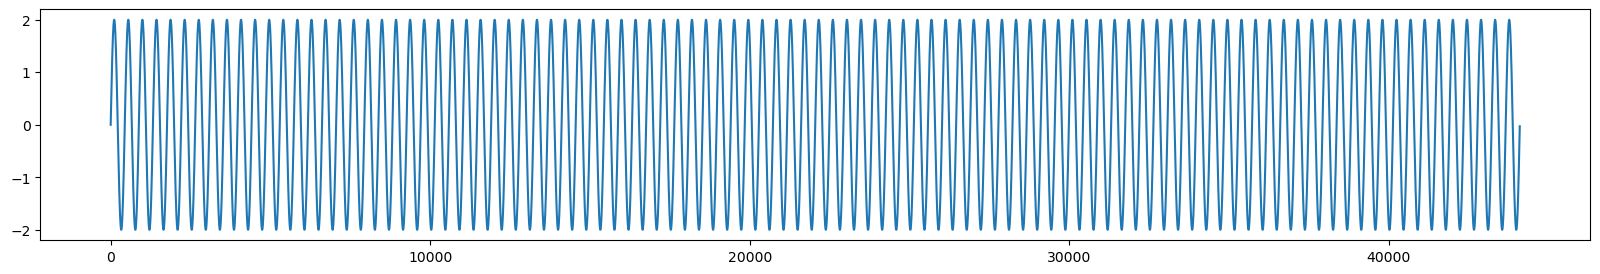

In [2]:
pd.Series(y, t).plot(kind='line', figsize=(20, 3))

In [7]:
from scipy.io import wavfile

y.astype(np.float32)

wavfile.write('_temp/test.wav', int(sr), y)

In [8]:
import IPython

IPython.display.Audio('_temp/test.wav', rate=sr, autoplay=True)